In [1]:

import numpy as np
import scipy
import skfem    
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
#import importlib  # for reloading routines
%matplotlib inline


### The complex Ginzburg-Landau model on a triangular mesh of the circle with Neumann boundary condition!!!

There are various forms of the complex Ginzburg-Landau equation for a field $A \in \mathbb{C}$.

From Cross' book
$$\partial_t A = A + (1 + i c_1) \nabla^2 A - (1-ic_3) |A|^2 A$$

From https://codeinthehole.com/tutorial/index.html  (Winterbottom) 
$$\partial_t A = A + (1 + i \alpha) \nabla^2 A - (1+ i\beta) |A|^2 A$$

These two  are the same if you send $\alpha \to c_1$ and
 $\beta \to - c_3$. 

from Chat\'e's and Manneville's 1996  review https://arxiv.org/abs/1608.07519
$$\partial_t A = A + (1 + i b_1) \nabla^2 A - (b_3-i) |A|^2 A$$

The real Ginzburg-Landau equation is setting $c_1, c_3=0$ of the Cross form or $\alpha=\beta=0$ of the Winterbottom form.
$$\partial_t A = A  + \nabla^2A - |A|^2 A$$

To rescale space you can multiply the Laplacian term by a factor.

In these forms the domain typically has size a few hundred so that interesting phenomena is seen. 
It is somewhat tedious to convert between Chate's form and the other two, but an advantage of 
that form is that they have conveniently classified the different behaviors as a function of $b_1, b_3$. 


The PDE  is obeyed in the domain $\Omega$, 
but on the boundary  $\partial \Omega$ we set $\frac{\partial u}{\partial n} = 0 $. 
This is a Neumann boundary condition. 

The weak/variational form of the problem is 
\begin{align}
\int_\Omega \partial_t u\ w\ dx &= \int_\Omega D_u (\Delta u) w \ dx + \int_\Omega g(u) \ w \ dx\\
\end{align}
with function $$g(u) = u-(1 + i\beta)|u|^2 u, \qquad {\rm or} \qquad  
g(u) = u - (b_3 - i ) |u|^2 u$$ depending upon which form of the equation one wants to use. 



The diffusion coefficient $D_u = (1 + i \alpha)$, 
and for all test functions $w \in \hat V$.  
We integrate by parts the terms that contain a Laplacian operator 
\begin{align}
\int_\Omega \partial_t u\ w \ dx =   - D_u  \int_\Omega \nabla u \nabla w \ dx 
+ \int_{\partial \Omega} \nabla u\ w \ ds
+ \int_\Omega g(u) \ w \ dx 
\end{align}
With normal derivative of $u$ equal to zero on the boundary, the  boundary terms in the above
equations can be neglected.
The weak form should be obeyed for all test functions $w \in \hat V$ with $\hat V = H^1(\Omega)$.
Since we lack Dirichlet regions of the boundary, there is no additional condition on $\hat V$. 
 We are following section 2.2.1 of the Fenics book.

We use a discrete subspace for $\hat V$ and assume we have a nice basis for it. 
We write each term as if it were an operator acting on a vector $w$ (aka the test function) in this basis. 

We split each time step into two pieces.  First updating $u,v$ with an implicit Crank-Nicolson step and 
then we take a first order forward Eulerian step to take into account the functions $R_u, R_v$. 

The Crank-Nicolson step for  $\partial_t u = F u  $  with $F$ a linear op is the following scheme 
\begin{align}
\partial_t u \sim \frac{u^{n+1} - u^n}{\Delta t} = \frac{1}{2} \left(F u^{n+1} + F u^n\right)
\end{align}
\begin{align}
\left( 1 - \frac{\Delta t F}{2 } \right) u^{n+1} = \left(1 + \frac{\Delta t F}{2 } \right) u^n \end{align}
\begin{align}
u^{n+1} = \left( 1 - \frac{ \Delta tF}{2} \right)^{-1} \left(1 + \frac{\Delta t F}{2 } \right)u^n
\end{align}
Taking into account the reaction equations for a diffusion reaction system 
\begin{align}
u^{n+1} &= \left( 1 - \frac{ \Delta t}{2 }D_u L \right)^{-1} \left(1 + \frac{\Delta t}{2 }D_uL  \right)u^n + 
\Delta t\ g(u^n)
\end{align}
where $L$ is the Laplacian operator. 

Note: we could bring the $u$ term into the linear operator when we use the Crank Nicolson method. 


In [9]:

from scipy.sparse.linalg import splu  # for sparse matrices, 
# returns something like invA with LU decomp which can be applied with solve to solve Ax = b for x

from skfem.models.poisson import laplace, mass
from skfem.visuals.matplotlib import plot

mcircs= skfem.MeshTri.init_circle(6,smoothed=False)  # make a triangular mesh of the unit circle, # is refinement level
rmax = 100 
mcirc = mcircs.translated(rmax * mcircs.p) # expand the mesh to be larger 
#mcirc = skfem.MeshTri(mcircs.p*rmax,mcircs.t)  # expand the mesh to be larger,  also works with points and triangles
# now it is a circle of radius 100
mcirc # show the mesh (only works if refinement level is below 7)

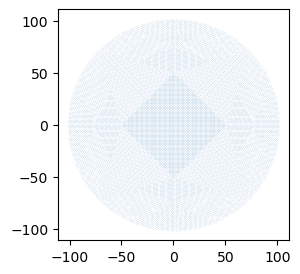

In [13]:

fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(mcirc.p[0],mcirc.p[1],'.',ms=0.1)
ax.set_aspect('equal')
# show the points of the mesh if there are a lot of them 

In [37]:
# display Amplitude and phase fields 
# calls skfem's plot routine 
def disp(mesh,u,basis,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=100)
    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')
    u_mag = np.absolute( u[basis.nodal_dofs.flatten()] ) 
    u_phase = np.angle ( u[basis.nodal_dofs.flatten()] )
    ax_j0 = plot(mesh, u_mag, shading='gouraud', ax = ax0)
    ax_j1 = plot(mesh, u_phase, shading='gouraud', ax = ax1)
    fig = ax0.get_figure()
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0,shrink=0.7)
    fig.colorbar(field1,shrink=0.7)
    title = ax0.set_title(f'|u|,   $t$ = {t:.3f}')
    title = ax1.set_title(f'phase of u')


# split integrator, crank nicholson for the diffusion parts and simply adding in the 
# non-linear function terms by hand afterwards 
# do a single timestep, return u fields and time 
# requires globals: dt, backsolve,  B
# note alpha, dt are used in definition of B and backsolve 
def one_step(t,u,beta):
    t += dt
    u = backsolve(B @ u)    
    u += g(u,beta)*dt
    return t,u



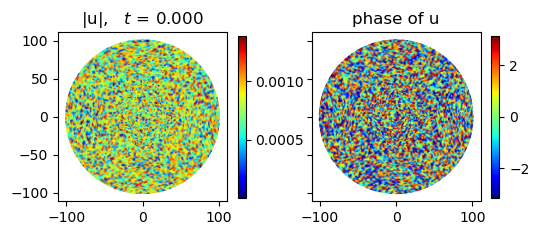

In [39]:
# set up the basis 
element = skfem.ElementTriP1()  # or ElementTriP2?  a triangular element
basis = skfem.Basis(mcirc, element)

# make random initial conditions for u field
nnodes = len(basis.doflocs[0])
u_init = np.zeros(nnodes, dtype = complex)
u_init += 1e-3*np.random.uniform(low=-1,high=1,size=nnodes)*1j
u_init += 1e-3*np.random.uniform(low=-1,high=1,size=nnodes)
# show initial conditions 
t=0
disp(mcirc,u_init,basis,t)

In [43]:

alpha = 2.  # must be defined here to make the Laplacian op = alpha = c_1 = b_1 of the different forms
D_u  = (1 + 1.j*alpha)  # diffusion coefficient 
dt = .01    # timestep 

L = -D_u * skfem.asm(laplace, basis)   # Laplacian for u field , is a bilinear form dot(grad u,grad v)
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) , bilinear form is  u*v

theta = 0.5                     # Crank–Nicolson algorithm for a diffusion PDE
A = M - theta * L * dt
B = M + (1. - theta) * L * dt   # 

backsolve = splu(A.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)

# backsolve(B @ u) gives A^-1 (B u) but with LU decomp
#   solve for x such that Ax = Bu computed using LU decomp of A
# see https://en.wikipedia.org/wiki/LU_decomposition and 
# https://docs.scipy.org/doc/scipy-1.14.0/reference/generated/scipy.sparse.linalg.splu.html

# the extra function:
def g(u,b_3):
    #return u-(1.0 + 1j*beta)*np.absolute(u)*np.absolute(u)*u  # Winterbottom's form
    return (u-(b_3 -1j)*np.absolute(u)*np.absolute(u)*u)   # Chate's form 


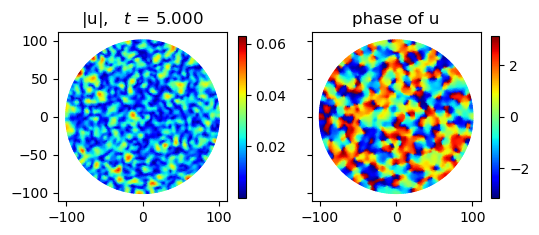

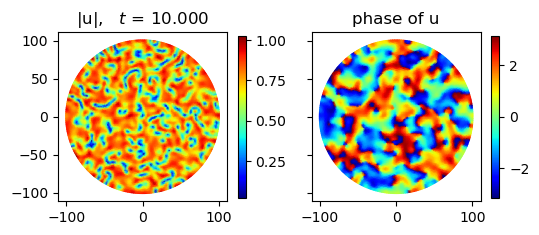

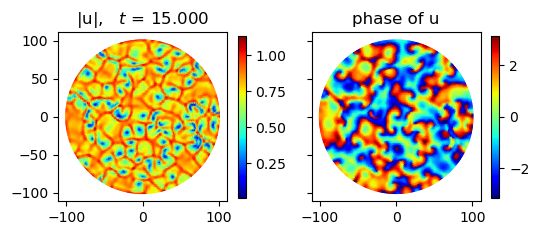

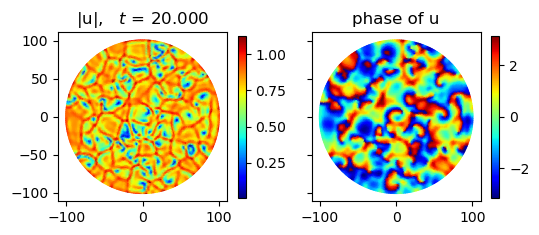

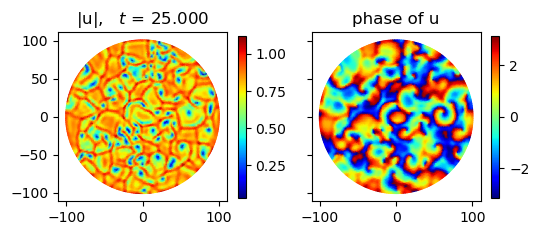

In [45]:
u = u_init;  t=0; 
b_3 = 1.3 # choose a nice param
for j in range(5):
    for i in range(500):
        t, u = one_step(t,u,b_3)  
    disp(mcirc,u,basis,t)

In [ ]:
# this might be correct, seems consistent with fig 3 in Chate review

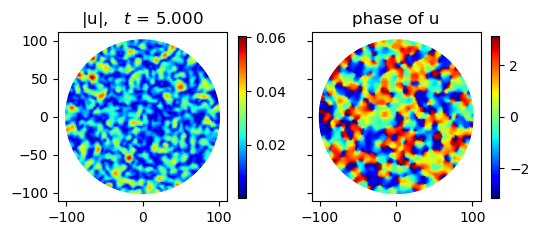

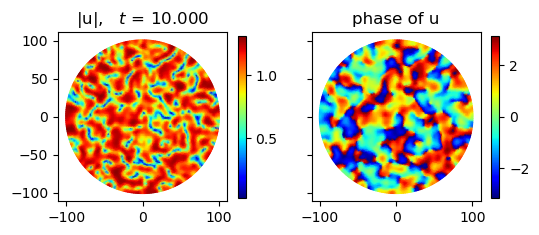

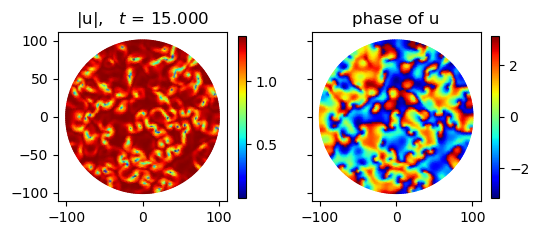

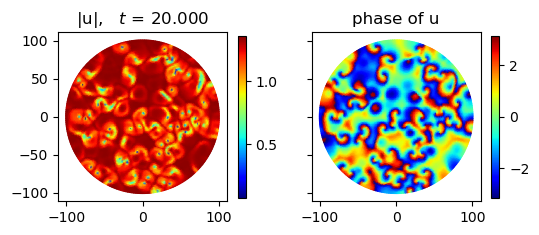

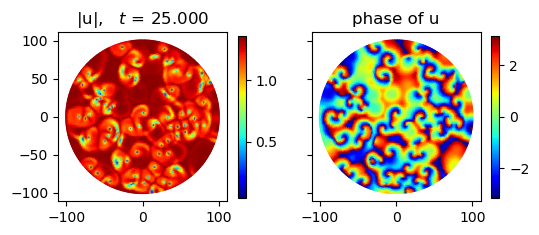

In [55]:

alpha = 0.  # must be defined here to make the Laplacian op    alpha = c_1 = b_1 of the different forms
D_u  = (1 + 1.j*alpha)  #diffusion coefficient 
dt = .01    # timestep 

L = -D_u * skfem.asm(laplace, basis)   # Laplacian for u field 
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) 

theta = 0.5                     # Crank–Nicolson algorithm for a diffusion PDE
A = M - theta * L * dt
B = M + (1. - theta) * L * dt

backsolve = splu(A.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)

# the extra function:
def g(u,b_3):
    return (u-(b_3 -1j)*np.absolute(u)*np.absolute(u)*u)   # Chate's form 

u = u_init;  t=0; 
b_3 = 0.56 # choose a nice param

for j in range(5):
    for i in range(500):
        t, u = one_step(t,u,b_3)  
    disp(mcirc,u,basis,t)

In [ ]:
# seems consistent with figure 3 by chate

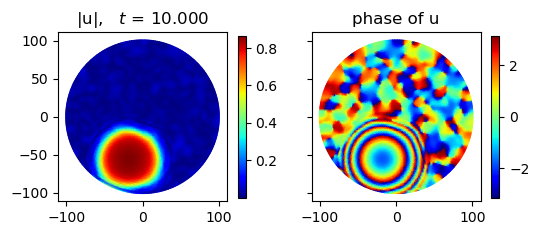

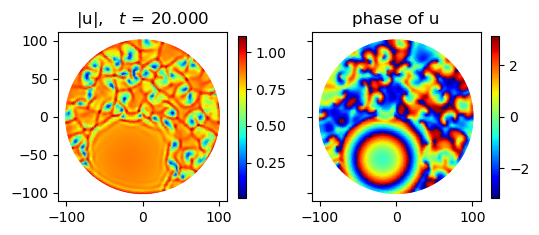

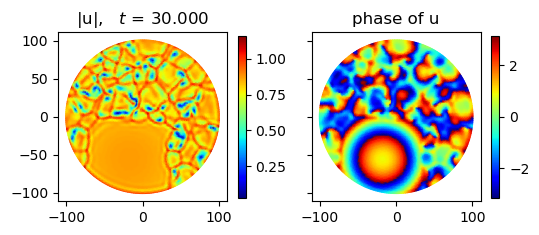

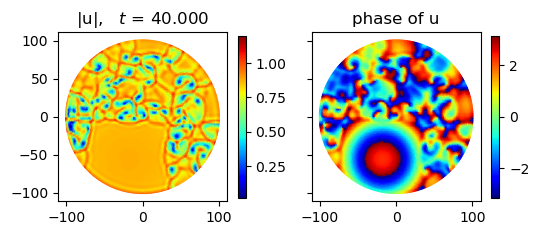

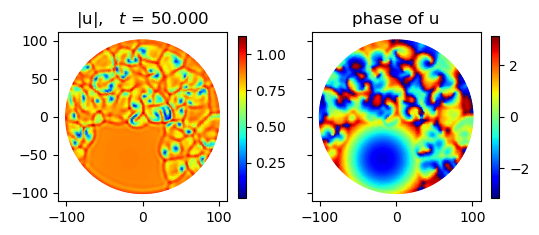

In [73]:

alpha = 2.  # must be defined here to make the Laplacian op    alpha = c_1 = b_1 of the different forms
D_u  = (1 + 1.j*alpha)  #diffusion coefficient 
dt = .01    # timestep 

L = -D_u * skfem.asm(laplace, basis)   # Laplacian for u field 
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) 

theta = 0.5                     # Crank–Nicolson algorithm for a diffusion PDE
A = M - theta * L * dt
B = M + (1. - theta) * L * dt

backsolve = splu(A.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)

# the extra function:
def g(u,b_3):
    return (u-(b_3 -1j)*np.absolute(u)*np.absolute(u)*u)   # Chate's form 

# make different initial conditions for u field
nnodes = len(basis.doflocs[0])
u_init2 = np.zeros(nnodes, dtype = complex)
u_init2 += 1e-5*np.random.uniform(low=-1,high=1,size=nnodes)*1j
u_init2 += 1e-5*np.random.uniform(low=-1,high=1,size=nnodes)
u_init2[80] = 1.0 + 0.1j

u = u_init2;  t=0; 
b_3 = 1.3 # choose a nice param

for j in range(5):
    for i in range(1000):
        t, u = one_step(t,u,b_3)  
    disp(mcirc,u,basis,t)

In [ ]:
# consistent with figure 6 by chate

In [ ]:
# below trying to put linear term into operator to see what this does (not much difference)

In [57]:
alpha = 2.  # must be defined here to make the Laplacian op = alpha = c_1 = b_1 of the different forms
D_u  = (1 + 1.j*alpha)  #diffusion coefficient 
dt = .01    # timestep 

M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) , bilinear form is  u*v
L = M - D_u * skfem.asm(laplace, basis)   # Laplacian for u field, is a bilinear form dot(grad u,grad v)
# including the linear term u here

theta = 0.5                     # Crank–Nicolson algorithm for a diffusion PDE
A = M - theta * L * dt
B = M + (1. - theta) * L * dt   # note signs of L flipped because weak form has opposite sign for Laplacian

backsolve = splu(A.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)

# the extra function:
def g(u,b_3):
    return (-(b_3 -1j)*np.absolute(u)*np.absolute(u)*u)   # Chate's form,  no linear term


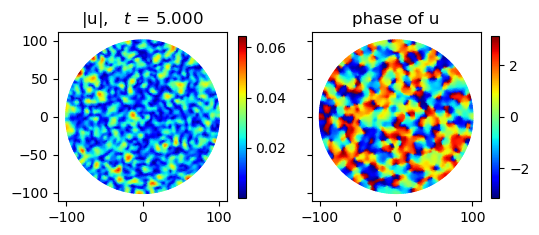

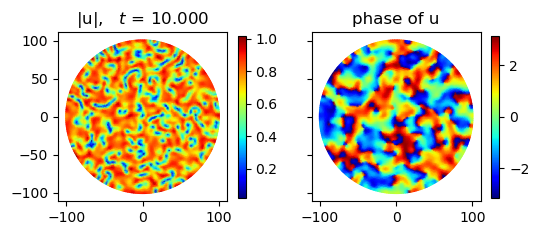

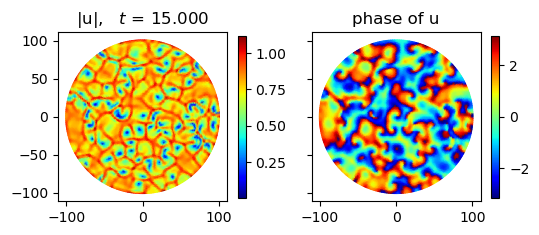

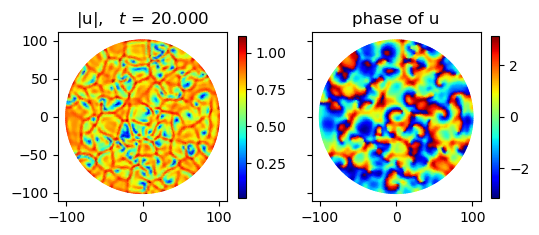

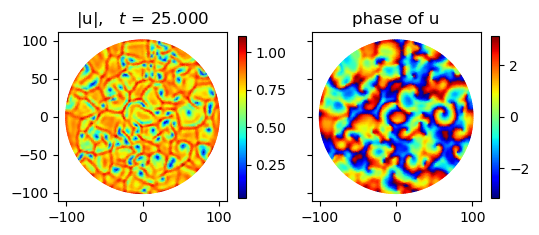

In [59]:
u = u_init;  t=0; 
b_3 = 1.3 # choose a nice param
for j in range(5):
    for i in range(500):
        t, u = one_step(t,u,b_3)  
    disp(mcirc,u,basis,t)